# One Float Sampling

This notebook tests Metropolis-Hastings on the one-float problem.

In [1]:
using AutomotiveDrivingModels
using AutoScenes
using Base.Test

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.6/AutoScenes.ji for module AutoScenes.


In [12]:
const FloatScene = Frame{Entity{Float64, Void, Int}};
function AutoScenes.Vars(scene::FloatScene, roadway::Void)
    x = scene[1].state
    return Vars(Float64[x], # vector containing the one variable
                [StateBounds(-x, 1-x)], # bounds are deltas so we can vary x by this much to remain in [0,1]
                [:x], # variable symbol
                [1])  # index of entity in the scene
end
function f1(
    vars::Vars,
    assignment::Assignment, # indeces of variables in vars
    roadway::Void,
    )::Float64

    return vars.values[assignment[1]] < 0.5
end
function f2(
    vars::Vars,
    assignment::Assignment, # indeces of variables in vars
    roadway::Void,
    )::Float64

    return vars.values[assignment[1]] ≥ 0.5
end;
function AutoScenes.assign_feature{F <: typeof(f1), Void}(
    f::F,
    scene::FloatScene,
    roadway::Void,
    vars::Vars,
    )

    return Assignment[(1,0)]
end
function AutoScenes.assign_feature{F <: typeof(f2), Void}(
    f::F,
    scene::FloatScene,
    roadway::Void,
    vars::Vars,
    )

    return Assignment[(1,0)]
end;

roadway = nothing
scenes = [
    FloatScene([Entity{Float64,Void,Int}(0.0,roadway,1)], 1),
    FloatScene([Entity{Float64,Void,Int}(1/4,roadway,1)], 1),
    FloatScene([Entity{Float64,Void,Int}(3/4,roadway,1)], 1),
    FloatScene([Entity{Float64,Void,Int}(3/4,roadway,1)], 1),
    FloatScene([Entity{Float64,Void,Int}(3/4,roadway,1)], 1),
    FloatScene([Entity{Float64,Void,Int}(1.0,roadway,1)], 1),
]
features = (f1, f2)
factorgraphs = [FactorGraph(features, scene, roadway) for scene in scenes];
model = FactorModel(features, [1.0,1.0]);

In [13]:
gen = FactorGraphSceneGenerator(model, Dict(:x => Normal(0.0,1.0)), 1000)

FactorGraphSceneGenerator(burnin=1000)

In [21]:
factorgraph = factorgraphs[1]
a = zeros(length(factorgraph.vars))
b = similar(a)
logPtilde_a = begin
    factorgraph.vars.values .+= a
    logPtilde_a = log_ptilde(gen.model.features, gen.model.weights, factorgraph.vars,
        factorgraph.assignments, factorgraph.roadway)
    factorgraph.vars.values .-= a
    return logPtilde_a
end

srand(0)
(a, logPtilde_a) = metropolis_hastings_step!(gen, factorgraph, a, b, logPtilde_a)

([0.0], 1.0)

In [15]:
metropolis_hastings!(gen, factorgraph)

1-element Array{Float64,1}:
 0.582138

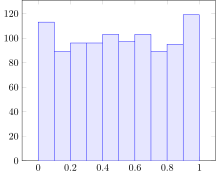

In [22]:
samples = Array{Float64}(1000)
for i in 1 : length(samples)
    samples[i] = metropolis_hastings!(gen, factorgraph)[1]
end
using PGFPlots
Axis(Plots.Histogram(samples, discretization=:specified), ymin=0)

In [24]:
Plo = count(samples .< 0.5)/length(samples)
@test isapprox(Plo, 0.5, atol=0.01)

Test Passed


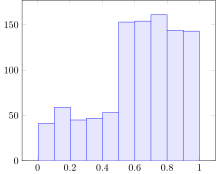

In [28]:
model = FactorModel(features, [1.0,2.0])
gen = FactorGraphSceneGenerator(model, Dict(:x => Normal(0.0,1.0)), 1000)
samples = Array{Float64}(1000)
for i in 1 : length(samples)
    samples[i] = metropolis_hastings!(gen, factorgraph)[1]
end
using PGFPlots
Axis(Plots.Histogram(samples, discretization=:specified), ymin=0)

In [29]:
P_target = exp(1) / (exp(2) + exp(1))
Plo = count(samples .< 0.5)/length(samples)
@test isapprox(P_target, P_target, atol=0.01)

Test Passed
